In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
df = pd.read_csv("Maternal_Health.csv")

In [5]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [6]:
df['Risk'] = pd.factorize(df['RiskLevel'])[0]
df.drop('RiskLevel', axis=1, inplace=True)

In [7]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,Risk
0,25,130,80,15.0,98.0,86,0
1,35,140,90,13.0,98.0,70,0
2,29,90,70,8.0,100.0,80,0
3,30,140,85,7.0,98.0,70,0
4,35,120,60,6.1,98.0,76,1


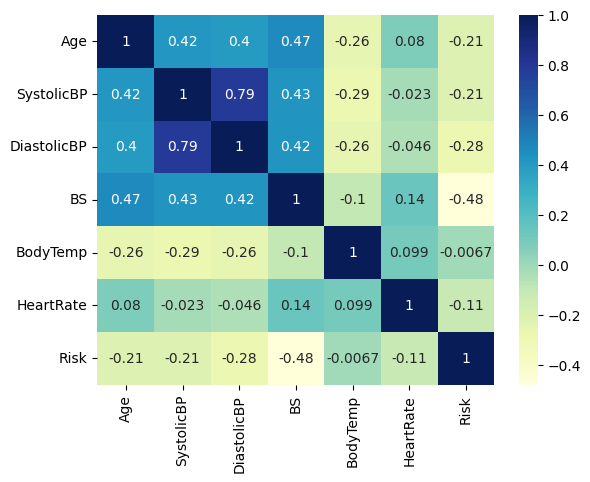

In [8]:
#PLOTS A GRAPH OF THE CORRELATION BETWEEN EACH VARIABLE IN THE DATASET
correlation_matrix = df.corr(numeric_only = True)
dataplot = sns.heatmap(correlation_matrix , cmap="YlGnBu", annot=True)

In [9]:
class Model(nn.Module):
    # Input Layer -> Hidden Layers -> Output Layer
    def __init__(self, in_features=6, h1=8, h2=9, h3=10, h4=12, out_features=3): 
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)  # Input to first hidden layer
        self.fc2 = nn.Linear(h1, h2)  # First to second hidden layer
        self.fc3 = nn.Linear(h2, h3)  # Second to third hidden layer
        self.fc4 = nn.Linear(h3, h4)  # Third to fourth hidden layer
        self.out = nn.Linear(h4, out_features)  # Fourth hidden to output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU after first hidden layer
        x = F.relu(self.fc2(x))  # Apply ReLU after second hidden layer
        x = F.relu(self.fc3(x))  # Apply ReLU after third hidden layer
        x = F.relu(self.fc4(x))  # Apply ReLU after fourth hidden layer
        x = self.out(x)  # Output layer (logits, no activation here)
        return x

In [10]:
# Seed Randomisation 
torch.manual_seed(41)
#Create an instance of our model
model = Model()

In [11]:
#Split data into train and test i.e X and Y respt.
X = df.drop('Risk' , axis=1 )
Y = df['Risk']

In [12]:
X.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,25,130,80,15.0,98.0,86
1,35,140,90,13.0,98.0,70
2,29,90,70,8.0,100.0,80
3,30,140,85,7.0,98.0,70
4,35,120,60,6.1,98.0,76


In [13]:
Y.head()

0    0
1    0
2    0
3    0
4    1
Name: Risk, dtype: int64

In [14]:
#CONVERT TO NUMPY ARRAYS
X = X.values
Y = Y.values

In [15]:
Y

array([0, 0, 0, ..., 0, 0, 2])

In [16]:
# Set the test size and random seed
test_size = 0.2
random_seed = 41

# Ensure reproducibility
np.random.seed(random_seed)

# Shuffle indices
indices = np.arange(len(X))
np.random.shuffle(indices)

# Calculate split index
test_count = int(len(X) * test_size)

# Split indices
test_indices = indices[:test_count]
train_indices = indices[test_count:]

# Create train-test split
X_train, X_test = X[train_indices], X[test_indices]
Y_train, Y_test = Y[train_indices], Y[test_indices]

# Print sizes to verify
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (812, 6), X_test shape: (202, 6)
Y_train shape: (812,), Y_test shape: (202,)


In [17]:
#Convert X features to flaot tensors ( 32 bit )
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [18]:
#Convert Y features to long tensors ( 64 bit )
Y_train = torch.LongTensor(Y_train)
Y_test = torch.LongTensor(Y_test)

In [19]:
model.parameters  #Model parameters for reference

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=6, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (fc3): Linear(in_features=9, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=3, bias=True)
)>

In [20]:
#Set criterion of model to measure error
criterion = nn.CrossEntropyLoss()
#Using Adam optimizer
# here , lr = learning rate of the model
optimizer = torch.optim.Adam( model.parameters() , lr = 0.01 )

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [21]:
#Epochs : one run through all the training data
epoch = 400
losses = []

In [22]:
for i in range(epoch):
    # Go forward and get a prediction
    Y_pred = model.forward(X_train)  #Get predicted result

    # Measure loss ( will be high at first)
    loss = criterion(Y_pred , Y_train) # predicted values VS train value

    # Keep track of losses
    losses.append(loss.detach().numpy())

    # Print every 10 epochs
    if i % 10 == 0:
        print(f'Epoch: {i} and Loss: {loss}')

    #Back-Propogation ( To optimize results) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 and Loss: 2.040106773376465
Epoch: 10 and Loss: 1.0873829126358032
Epoch: 20 and Loss: 1.0851492881774902
Epoch: 30 and Loss: 1.080920696258545
Epoch: 40 and Loss: 1.0771112442016602
Epoch: 50 and Loss: 1.0667076110839844
Epoch: 60 and Loss: 1.0229519605636597
Epoch: 70 and Loss: 0.9679008722305298
Epoch: 80 and Loss: 0.9226715564727783
Epoch: 90 and Loss: 0.8824564218521118
Epoch: 100 and Loss: 0.8575403094291687
Epoch: 110 and Loss: 0.8636102676391602
Epoch: 120 and Loss: 0.8309838175773621
Epoch: 130 and Loss: 0.8291682600975037
Epoch: 140 and Loss: 0.8163794279098511
Epoch: 150 and Loss: 0.8047122955322266
Epoch: 160 and Loss: 0.8021747469902039
Epoch: 170 and Loss: 0.8008227944374084
Epoch: 180 and Loss: 0.7891103625297546
Epoch: 190 and Loss: 0.7791279554367065
Epoch: 200 and Loss: 0.7728971838951111
Epoch: 210 and Loss: 0.7861909866333008
Epoch: 220 and Loss: 0.7730079889297485
Epoch: 230 and Loss: 0.7661519050598145
Epoch: 240 and Loss: 0.7636004686355591
Epoch: 250 an

Text(0.5, 0, 'Epochs')

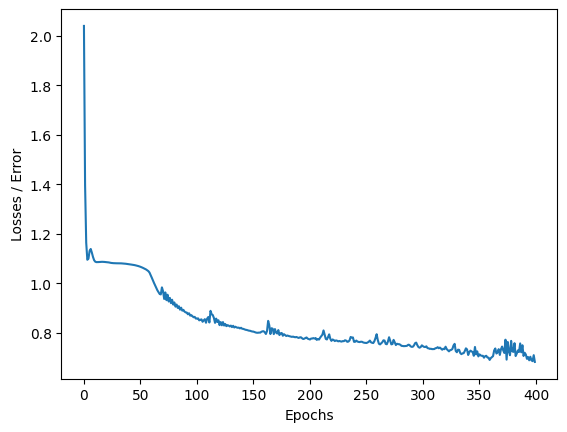

In [23]:
plt.plot(range(epoch) , losses)
plt.ylabel("Losses / Error")
plt.xlabel("Epochs")

In [24]:
with torch.no_grad(): #Turn off back propogation
    #We use the 20% set i.e test set we defined earlier
    Y_eval = model.forward(X_test) 

    #Fine the loss/error
    loss = criterion(Y_eval , Y_test)

In [25]:
loss #not great , it should be equal to previous train loss

tensor(0.7911)

In [26]:
correct = 0  # Variable to find how many predictions we got right

with torch.no_grad():
    for i , data in enumerate(X_test):
        Y_val = model.forward(data)
        
        # Will tell us the prediction of the neural network
        print(f'{i+1}.) {str(Y_val)}     \t {Y_test[i]}   \t {Y_val.argmax().item()}')
        #The highest number in each row is the prediction for that image

        #Correcrt OR not
        if Y_val.argmax().item() == Y_test[i]:
            correct += 1

    print(f'\nCorrect Predictions = {correct}')

1.) tensor([-1.6837,  1.8222,  1.3422])     	 1   	 1
2.) tensor([0.5122, 0.1182, 0.0093])     	 2   	 0
3.) tensor([-0.5850,  0.9344,  0.6772])     	 1   	 1
4.) tensor([-1.6859,  1.5136,  1.3458])     	 1   	 1
5.) tensor([-1.0859,  1.0366,  0.9827])     	 1   	 1
6.) tensor([-0.9132,  1.0454,  1.8046])     	 1   	 2
7.) tensor([-1.1804,  1.1555,  1.0393])     	 1   	 1
8.) tensor([ 3.2687, -0.9873,  0.3055])     	 0   	 0
9.) tensor([-0.4993,  1.1370,  0.6237])     	 1   	 1
10.) tensor([-1.6321,  2.3675,  0.1223])     	 0   	 1
11.) tensor([-0.3727,  1.6110, -0.3796])     	 1   	 1
12.) tensor([ 3.8720, -2.0309,  1.1035])     	 0   	 0
13.) tensor([ 3.1508, -1.7364,  1.0393])     	 0   	 0
14.) tensor([-1.2661,  1.2270,  1.0913])     	 2   	 1
15.) tensor([ 6.1081, -2.9064,  1.2360])     	 0   	 0
16.) tensor([-1.4761,  1.5151,  1.2180])     	 1   	 1
17.) tensor([-1.3204,  1.2228,  1.1244])     	 2   	 1
18.) tensor([-0.7578,  0.9820,  1.8268])     	 1   	 2
19.) tensor([-0.0612, 

Confusion Matrix:
[[44 11  2]
 [ 4 74  4]
 [13 35 15]]
Axes(0.125,0.11;0.62x0.77)


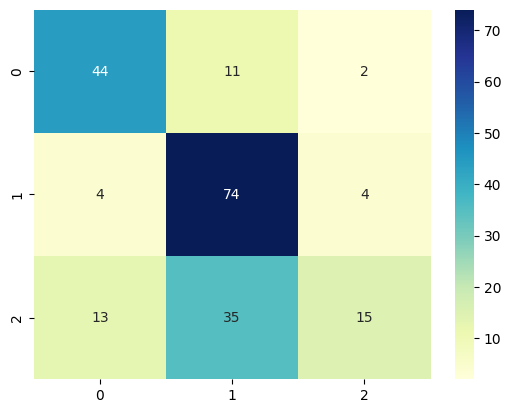

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get model predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    Y_pred = model(X_test)  # Get predictions
    _, predicted = torch.max(Y_pred, 1)  # Get class with highest probability

# Convert predicted labels (PyTorch tensor) to NumPy array
predicted = predicted.cpu().numpy()  # Move to CPU if on GPU

# If Y_test is a PyTorch tensor, move it to CPU and convert to NumPy array
if isinstance(Y_test, torch.Tensor):
    Y_test = Y_test.cpu().numpy()  # Move to CPU if Y_test is a tensor

# Generate confusion matrix
cm = confusion_matrix(Y_test, predicted)
# Print confusion matrix as a 2D array

print("Confusion Matrix:")
print(cm)
print(sns.heatmap(cm , cmap="YlGnBu", annot=True))


In [31]:
print("Accuracy:", accuracy_score(Y_test, predicted))
print("Classification Report:")
print(classification_report(Y_test, predicted))


Accuracy: 0.6584158415841584
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.75        57
           1       0.62      0.90      0.73        82
           2       0.71      0.24      0.36        63

    accuracy                           0.66       202
   macro avg       0.68      0.64      0.61       202
weighted avg       0.68      0.66      0.62       202



# I GIVE UP
# THATS AS ACCURATE AS I CAN GET IT
# I HATE MY LIFE